# Sustainable Mobility and Emission Reduction in Melbourne

**Duration:** 90 minutes  
**Level:** Intermediate  
**Pre-requisite Skills:** Python, APIs, Pandas, Data Visualization

## Scenario

Melbourne is known for its liveability and progressive sustainability efforts, but like many growing cities, it's facing the pressures of increased traffic and rising carbon emissions. To reduce its environmental footprint and improve urban mobility, the city has been actively promoting walking and cycling as alternatives to car use.

This project explores how active transport—specifically walking and biking—can play a major role in reducing emissions across Melbourne. By analyzing real-time sensor data provided by the City of Melbourne, we aim to understand when and where people are choosing sustainable transport options, and how much CO₂ is potentially being avoided as a result.

Through this analysis, we hope to provide clear, actionable insights that support Melbourne’s sustainability goals, while also highlighting opportunities for infrastructure improvements that encourage more people to choose walking and cycling over driving.


## Problem Description

While Melbourne has seen great efforts to promote walking and cycling, most transportation reports still focus on emissions produced rather than emissions prevented. But every time someone walks or cycles instead of taking a car, that's an avoided car trip—and avoided emissions.

This project flips the typical emissions analysis by focusing on **emissions avoided** through active transport. Using live data on pedestrian and cyclist activity, we aim to estimate how many short trips might have otherwise been taken by car, and how much CO₂ was saved in the process.

We’ll also explore patterns in this sustainable behavior: what time of day people choose to walk or bike, which locations have the most activity, and how different zones in the city compare. These insights can help guide policy, public investment, and future infrastructure upgrades.


## Challenge

> How can we use real-world data to measure and support Melbourne’s shift toward greener transportation?

To answer this, we:
- Use live APIs to collect pedestrian and bicycle sensor data from across the city
- Clean and merge the datasets based on time and location
- Estimate how much CO₂ would have been produced if these trips were done by car
- Calculate the environmental savings from walking and biking
- Identify the most sustainable hours of the day (“green hours”)
- Highlight key hotspots and zones for infrastructure investment

By tackling this challenge, we not only explore the impact of active transport, but also create tools to help Melbourne build a cleaner, healthier, and more sustainable transport network.


## Sustainability Impact

This project directly supports Melbourne’s commitment to sustainability and climate action, aligning with two key United Nations Sustainable Development Goals:

- **SDG 11: Sustainable Cities and Communities**  
  By encouraging safe, accessible, and low-emission transport options like walking and cycling.

- **SDG 13: Climate Action**  
  By estimating emissions avoided through active transport and helping the city track progress toward its net-zero goals.

The City of Melbourne has committed to becoming a net-zero emissions city by 2040. Projects like this help make that possible by quantifying the impact of behavior change and providing data to guide better transport and planning decisions.


## Importing Required Libraries

To work with and visualize the data effectively, we begin by importing all necessary Python libraries.

- `pandas` and `numpy` are used for loading, cleaning, and transforming the datasets, as well as performing numerical calculations.
- `requests` allows us to fetch real-time data directly from the City of Melbourne Open Data APIs using HTTP requests.
- `matplotlib` and `seaborn` help us create clear and informative visualizations to explore patterns in pedestrian and cycling data.
- `folium` is used to build interactive maps, allowing us to spatially represent sensor locations and mobility activity across the city.

These libraries provide a strong foundation for handling data efficiently and presenting insights in a visual, easy-to-understand format.


In [ ]:
# Install required libraries (run only once)
!pip install pandas numpy requests geopandas matplotlib seaborn folium --quiet


In [ ]:
# Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster


## Loading Pedestrian Data

To analyze sustainable mobility in Melbourne, we begin by collecting real-time pedestrian traffic data from the City of Melbourne Open Data API. The dataset used is called `pedestrian-counting-system-monthly-counts-per-hour`, which records hourly foot traffic detected by sensors installed across various locations in the city.

We use the API v2.1 `/records` endpoint to fetch this data dynamically using the `requests` library. The request is limited to 100 records per call, as per the API's constraints. The retrieved data is then loaded into a Pandas DataFrame for further analysis.

This dataset allows us to track pedestrian activity across different hours and locations, forming the foundation for estimating how walking contributes to CO₂ reduction and sustainable transport goals in Melbourne.


In [ ]:
import requests
import pandas as pd

# Correct dataset ID
dataset_id = "pedestrian-counting-system-monthly-counts-per-hour"

# API v2.1 /records endpoint
url = f"https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/{dataset_id}/records"

# Use no filters and keep limit <= 100 (max for v2.1 per request)
params = {
    "limit": 100  # You can paginate later if needed
}

# Make the request
response = requests.get(url, params=params)

# Parse the response
if response.status_code == 200:
    data = response.json()['results']
    ped_df = pd.DataFrame(data)
    print("✅ Data loaded successfully! Shape:", ped_df.shape)
    display(ped_df.head())
else:
    print(f"❌ Failed to fetch pedestrian data: {response.status_code}")
    print(response.text)


✅ Data loaded successfully! Shape: (100, 9)


,id,location_id,sensing_date,hourday,direction_1,direction_2,pedestriancount,sensor_name,location
0,132620240208,132,2024-02-08,6,26,22,48,King335_T,"{'lon': 144.95386444, 'lat': -37.81267639}"
1,52820250310,52,2025-03-10,8,48,33,81,Eli263_T,"{'lon': 144.9619401, 'lat': -37.81252157}"
2,521420221205,52,2022-12-05,14,361,255,616,Eli263_T,"{'lon': 144.9619401, 'lat': -37.81252157}"
3,70620221117,70,2022-11-17,6,5,10,15,Errol20_T,"{'lon': 144.94946228, 'lat': -37.80456984}"
4,1091020241216,109,2024-12-16,10,85,103,188,LatWill_T,"{'lon': 144.95621105, 'lat': -37.81193681}"


## Preprocessing Pedestrian Data

Once the pedestrian dataset is loaded, we perform a series of preprocessing steps to prepare it for analysis.

1. **Datetime Conversion:**  
   The `sensing_date` column is converted into a standard datetime format to allow easier time-based analysis.

2. **Column Renaming:**  
   The `hourday` column, which indicates the hour of the day, is renamed to `hour` for clarity.

3. **Trip Volume Calculation:**  
   The total number of pedestrians detected at each sensor is calculated by summing the counts from both directions (`direction_1` and `direction_2`), and stored in a new column named `count`.

4. **Time Features Extraction:**  
   We extract additional useful time features such as the weekday (e.g., Monday, Tuesday) and month name from the `sensing_date` column.

5. **Geolocation Parsing:**  
   Each sensor’s geographic coordinates are extracted from the `location` dictionary and split into two new columns: `latitude` and `longitude`.

These preprocessing steps ensure that the dataset is clean, consistent, and ready for merging with other transport datasets or for use in time-based and spatial analyses.


In [ ]:
# Import necessary modules
import pandas as pd

# Convert sensing_date to datetime
ped_df['sensing_date'] = pd.to_datetime(ped_df['sensing_date'], errors='coerce')

# Rename hour column (it’s labeled 'hourday')
ped_df.rename(columns={'hourday': 'hour'}, inplace=True)

# Calculate total count by adding both directions
ped_df['count'] = ped_df['direction_1'] + ped_df['direction_2']

# Extract weekday and month
ped_df['weekday'] = ped_df['sensing_date'].dt.day_name()
ped_df['month'] = ped_df['sensing_date'].dt.month_name()

# Extract lat/lon from location column (it's a dict)
ped_df['latitude'] = ped_df['location'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
ped_df['longitude'] = ped_df['location'].apply(lambda x: x['lon'] if isinstance(x, dict) else None)

# Final preview
ped_df[['sensor_name', 'sensing_date', 'hour', 'weekday', 'count', 'latitude', 'longitude']].head()


,sensor_name,sensing_date,hour,weekday,count,latitude,longitude
0,King335_T,2024-02-08,6,Thursday,48,-37.812676,144.953864
1,Eli263_T,2025-03-10,8,Monday,81,-37.812522,144.961940
2,Eli263_T,2022-12-05,14,Monday,616,-37.812522,144.961940
3,Errol20_T,2022-11-17,6,Thursday,15,-37.804570,144.949462
4,LatWill_T,2024-12-16,10,Monday,188,-37.811937,144.956211


## Loading Bicycle Data

In addition to pedestrian activity, understanding cycling patterns is essential to evaluating Melbourne’s sustainable mobility landscape. For this, we use the `annual-bike-counts-super-tuesday` dataset available through the City of Melbourne Open Data API.

This dataset contains counts of cyclists observed on Super Tuesday, an annual day dedicated to measuring bike usage across key locations in the city. It includes sensor locations, time labels, directional traffic data, and coordinates for mapping.

We use the API v2.1 `/records` endpoint to request a batch of 100 records (the maximum allowed per call) and load the results into a Pandas DataFrame. This enables real-time integration with other transport datasets and ensures that the analysis reflects current mobility trends in the city.

The bicycle data is later merged with pedestrian data to provide a complete view of active transport and its environmental impact.


In [ ]:
import requests
import pandas as pd

# Dataset ID and URL
dataset_id = "annual-bike-counts-super-tuesday"
url = f"https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/{dataset_id}/records"

# API call with valid limit
params = {
    "limit": 100  # max allowed for v2.1
}

# Request
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()['results']
    bike_df = pd.DataFrame(data)
    print("🚴‍♂️ Bike data loaded successfully! Shape:", bike_df.shape)
    display(bike_df.head())
else:
    print(f"❌ Failed to fetch bike count data: {response.status_code}")
    print(response.text)


🚴‍♂️ Bike data loaded successfully! Shape: (100, 82)


,state,electorate,site_id,latitude,longitude,legs,description,layout_1,layout_1_enter,layout_2,...,7_00_am,7_15_am,7_30_am,7_45_am,8_00_am,8_15_am,8_30_am,8_45_am,location,geolocation
0,VIC,Melbourne,4399,-37.787979,144.959000,2,"Royal Pde/shared path [N], Royal Pde/shared pa...",5,185,186,...,None,None,None,None,None,None,None,None,POINT (144.959 -37.787979),"{'lon': 144.959, 'lat': -37.787979}"
1,VIC,Melbourne,4416,-37.808155,144.968765,4,"Exhibition St [N], La Trobe St [E], Exhibition...",6,186,70,...,None,None,None,None,None,None,None,None,POINT (144.968765 -37.808155),"{'lon': 144.968765, 'lat': -37.808155}"
2,VIC,Melbourne,4421,-37.809612,144.963791,4,"La Trobe St [E], Swanston St (city) [S], La Tr...",70,250,160,...,None,None,None,None,None,None,None,None,POINT (144.963791 -37.809612),"{'lon': 144.963791, 'lat': -37.809612}"
3,VIC,Melbourne,4422,-37.809940,144.935898,4,"Upstream direction [N], Capital City Trail [E]...",8,188,108,...,None,None,None,None,None,None,None,None,POINT (144.935898 -37.80994),"{'lon': 144.935898, 'lat': -37.80994}"
4,VIC,Melbourne,4423,-37.810334,144.961361,4,"La Trobe towards Exhibition St [E], Elizabeth ...",70,250,160,...,None,None,None,None,None,None,None,None,POINT (144.961361 -37.810334),"{'lon': 144.961361, 'lat': -37.810334}"


## Preprocessing Bicycle Data

The bicycle dataset provides cycling volumes recorded at specific time intervals (e.g., every 15 minutes) across multiple sites in Melbourne. To make this data usable for analysis, we need to reshape and clean it.

1. **Identifying Time Columns:**  
   The dataset includes several time-based columns such as `7_00_am`, `8_15_am`, etc. These columns represent specific time intervals when bike counts were recorded. We isolate these columns for transformation.

2. **Reshaping the Data:**  
   Using the `melt()` function, we pivot the dataset from wide to long format so that each row represents a single time-based observation at a given site.

3. **Removing Empty Records:**  
   Rows with no recorded bike counts are dropped to ensure clean analysis.

4. **Formatting Time Labels:**  
   The original column names (like `7_15_am`) are reformatted into more readable time strings (like `07:15 AM`) for clarity and potential conversion to datetime formats.

This transformation helps us align cycling data with pedestrian data by time and location, and prepares it for aggregation, comparison, and visualization.


In [ ]:
# Step 1: Identify time columns (e.g., '7_00_am', '7_15_am', etc.)
time_cols = [col for col in bike_df.columns if col.endswith('_am') or col.endswith('_pm')]

# Step 2: Melt into long format: one row per time entry
bike_long_df = bike_df.melt(
    id_vars=['site_id', 'latitude', 'longitude', 'description'],
    value_vars=time_cols,
    var_name='time_label',
    value_name='bike_count'
)

# Step 3: Drop rows with no count
bike_long_df.dropna(subset=['bike_count'], inplace=True)

# Step 4: Standardize time labels (e.g., 7_00_am → 07:00 AM)
bike_long_df['time_label'] = bike_long_df['time_label'].str.replace('_', ':').str.replace(':am', ' AM').str.replace(':pm', ' PM')

# Preview
bike_long_df.head()


,site_id,latitude,longitude,description,time_label,bike_count
68,4399,-37.787979,144.959000,"Royal Pde/shared path [N], Royal Pde/shared pa...",7:00 AM,60
69,4417,-37.808903,144.966278,"La Trobe St [E], Russell St (city) [S], La Tro...",7:00 AM,29
70,4423,-37.810334,144.961361,"La Trobe towards Exhibition St [E], Elizabeth ...",7:00 AM,51
71,4427,-37.811749,144.956451,"La Trobe towards Exhibition St [E], William St...",7:00 AM,73
72,4429,-37.812531,144.953873,"La Trobe [E], King St (city) [S], La Trobe St ...",7:00 AM,36


## Final Structuring of Bicycle Data

To enable better time-based analysis and merging with pedestrian data, we perform a few final formatting steps.

1. **Convert Time Labels to Time Format:**  
   The `time_label` column, which holds time in string format (e.g., `"07:15 AM"`), is converted into a proper `datetime.time` format. This makes it easier to sort and align with other time-based datasets.

2. **Reset Index:**  
   The index is reset to clean up the DataFrame after reshaping and filtering, ensuring the rows are numbered sequentially.

3. **Preview Final Structure:**  
   The dataset is now in long format, with each row representing one time-based observation of bike traffic at a specific location. It includes site ID, description, time of day, bike count, and latitude/longitude for mapping and analysis.

This finalized structure is now ready for merging with pedestrian data, spatial mapping, and CO₂ emission comparisons.


In [ ]:
# Convert time_label to datetime.time format (optional for sorting)
import datetime

bike_long_df['bike_time'] = pd.to_datetime(bike_long_df['time_label'], format='%I:%M %p', errors='coerce').dt.time


In [ ]:
# Reset index for clean output
bike_long_df.reset_index(drop=True, inplace=True)

# Final structure
bike_long_df[['site_id', 'description', 'bike_time', 'bike_count', 'latitude', 'longitude']].head()


,site_id,description,bike_time,bike_count,latitude,longitude
0,4399,"Royal Pde/shared path [N], Royal Pde/shared pa...",07:00:00,60,-37.787979,144.959000
1,4417,"La Trobe St [E], Russell St (city) [S], La Tro...",07:00:00,29,-37.808903,144.966278
2,4423,"La Trobe towards Exhibition St [E], Elizabeth ...",07:00:00,51,-37.810334,144.961361
3,4427,"La Trobe towards Exhibition St [E], William St...",07:00:00,73,-37.811749,144.956451
4,4429,"La Trobe [E], King St (city) [S], La Trobe St ...",07:00:00,36,-37.812531,144.953873


## Visualizing Pedestrian Patterns

To understand how pedestrian activity varies across time, we create visualizations that show hourly and daily trends.

1. **Total Counts by Hour of Day:**  
   This bar plot displays aggregated pedestrian traffic for each hour of the day across all sensors. It helps identify peak walking times — typically corresponding to commuting hours or lunchtime.

2. **Total Counts by Day of Week:**  
   This visualization shows how pedestrian volume changes throughout the week. It can help distinguish between weekday commuting patterns and weekend leisure movement.

These visual insights help planners and decision-makers understand when foot traffic is highest, and inform when and where to allocate resources or prioritize pedestrian-friendly infrastructure upgrades.


<ipython-input-24-17e1f112ec38>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ped_df, x="hour", y="count", estimator=sum, ci=None, palette="viridis")
<ipython-input-24-17e1f112ec38>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ped_df, x="hour", y="count", estimator=sum, ci=None, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128099 (\N{FOOTPRINTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


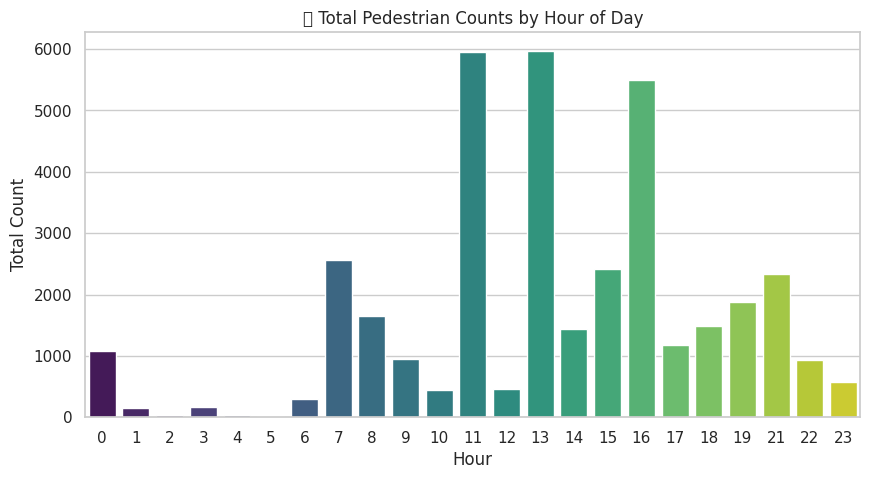

<ipython-input-24-17e1f112ec38>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ped_df, x="weekday", y="count", estimator=sum, ci=None,
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128099 (\N{FOOTPRINTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


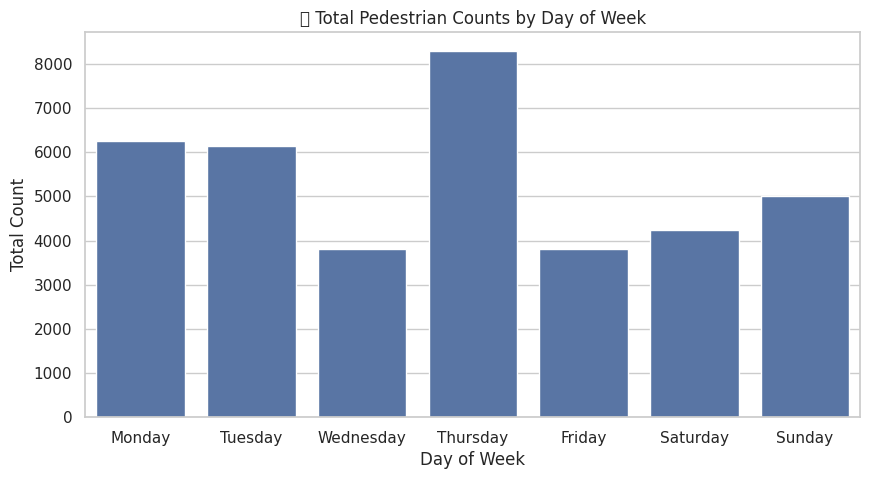

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot: Total counts by hour
plt.figure(figsize=(10, 5))
sns.barplot(data=ped_df, x="hour", y="count", estimator=sum, ci=None, palette="viridis")
plt.title("👣 Total Pedestrian Counts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Total Count")
plt.show()

# Plot: Total counts by weekday
plt.figure(figsize=(10, 5))
sns.barplot(data=ped_df, x="weekday", y="count", estimator=sum, ci=None,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("👣 Total Pedestrian Counts by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Count")
plt.show()


## Mapping Pedestrian Sensor Activity

To visualize where pedestrian traffic is concentrated across Melbourne, we use `folium` to create an interactive map of sensor locations.

Each sensor is represented as a circle marker, where:
- The **size** of the marker reflects the total pedestrian count at that location and time
- The **color** and **popups** provide additional context like the sensor name, date, hour, and count
- A **marker cluster** is used to improve performance and readability when zoomed out

This spatial representation helps identify foot traffic hotspots and walkable zones, which are crucial for understanding how infrastructure supports active mobility and where improvements may be needed.


In [ ]:
import folium
from folium.plugins import MarkerCluster

# Center map
map_center = [ped_df['latitude'].mean(), ped_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=14)
marker_cluster = MarkerCluster().add_to(m)

# Add markers
for i, row in ped_df.iterrows():
    popup = f"Sensor: {row['sensor_name']}<br>Date: {row['sensing_date'].date()}<br>Hour: {row['hour']}<br>Count: {row['count']}"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=min(row['count'] / 20, 10),
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=popup
    ).add_to(marker_cluster)

m  # Display map


##  Project Progress Summary

As part of the ongoing project titled **“Sustainable Mobility and Emission Reduction in Melbourne,”** we have successfully completed the initial phases, which include integrating live datasets from the City of Melbourne Open Data API, preprocessing both pedestrian and bicycle data, and visualizing pedestrian trends through hourly, weekday-based, and map-based analyses. These foundational steps help highlight active mobility patterns across the city and lay the groundwork for deeper sustainability insights.

In the upcoming weeks, the project will continue with the integration of bicycle activity data, merging datasets based on time and spatial proximity, and estimating carbon emissions avoided due to active transport modes. Further analysis will include identifying walk- and bike-dominant zones, calculating peak “green hours” for sustainable transport, and mapping out CO₂ savings across key locations. The final deliverables will include advanced visualizations, emissions analysis, and policy-aligned recommendations supporting Melbourne’s climate and mobility goals under SDG 11 and SDG 13.
